# Создание графа

## Извлечение информации из Википедии

In [1]:
import pandas as pd
import wikipediaapi
from tqdm import tqdm

def scrape_wikipedia(name_topic, language = 'en'):
    '''
    функция, которая производит выгрузку названий и категорий статей Википедии по заданной теме (name_topic)
    также предусмотрена возможность выгружать данные не только с англоязчной Википедии
    '''
    def link_to_wikipedia(link):
        '''
        функция, которая выгружает необходимую информации о статье Википедии по ссылке (link), при условии ее существования
        '''
        try:
            page = api_wikipedia.page(link)
            if page.exists() and page.categories:
                return {'page': link,  'categories': list(page.categories.keys())}
        except:
            return None

    # производим подключение к Wikipedia ARI, данные извлекаются в формате WIKI, а не HTML

    api_wikipedia = wikipediaapi.Wikipedia(language=language, extract_format=wikipediaapi.ExtractFormat.WIKI)
    
#     достаем страницы по топику, то есть по моей предметной области
    name_of_page = api_wikipedia.page(name_topic)
#     если не существует страниц по топику, то выводит на экран, что статей по топику не существует
    if not name_of_page.exists():
        print(f'Page {name_of_page} is not present')
        return
#   сохраняем ссылки на страницы по топику
    links_to_page = list(name_of_page.links.keys())
    
#     делает бегущую заполняющуюся полоску, чтоб отслеживать процесс
#   в origin записываем набор данных о первой странице по топику, затем сюда записываются остальные результаты выгрузки статей по топику
#   если они существуют
    origin = [{'page': name_topic,  'categories': list(name_of_page.categories.keys())}]
    for link in tqdm(links_to_page):
        if link_to_wikipedia(link)!=None:
            origin.append(link_to_wikipedia(link))
    

#   сохраняем собранные данные в таблицу Pandas
    origin = pd.DataFrame(origin)
    namespaces = ('Wikipedia', 'Special', 'Talk', 'LyricWiki', 'File', 'MediaWiki',
                  'Template', 'Help', 'User', 'Category talk', 'Portal talk','Category','Portal')
#   отбираем только те топики, название которых не содержится в namespaces, тк это не нужные статьи 
    origin = origin[~(origin['page'].str.startswith(namespaces, na=True))]
#     в категориях отрезаем первые символы до последнего двоеточия 
#     (Caregory:):
    origin['categories'] = origin.categories.apply(lambda a: [b[len(b)-b[::-1].index(':'):] for b in a])
#     выводим сколько страниц было просмотрено
    print('Scraped pages', len(origin))
#   в результате выводим таблицу с собранными данными
    return origin

In [41]:
#запускаю функцию для выгрузки информации из Википедии по теме brand
data = scrape_wikipedia('brand', language = 'en')

100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [09:36<00:00,  1.04it/s]

Scraped pages 579


In [45]:
data.shape

(579, 2)

In [55]:
# распаковка списка в ячейках
data_new = data.explode('categories')
# сохранение результатов выгрузки в файл формата csv
data_new.to_csv('data for work.csv')

## Обработка данных 

In [56]:
import pandas as pd
from pyvis.network import Network
import networkx as nx

In [60]:
# считывание данных из файла с выгруженными данными 
data_new = pd.read_csv('data for work.csv').drop(['Unnamed: 0'],axis=1)
# data.categories = data.categories.str.replace('[','', regex=True)
# data.categories = data.categories.str.replace(']','', regex=True)
# data.categories = data.categories.apply(lambda x: x.split(', '))
#data.categories = data.categories.str.replace("'",'')
data_new

,page,categories
0,brand,All articles containing potentially dated stat...
1,brand,All articles needing additional references
2,brand,All articles with unsourced statements
3,brand,Articles containing potentially dated statemen...
4,brand,Articles needing additional references from Fe...
...,...,...
11760,Youth activism,missing periodical
11761,Youth activism,Education issues
11762,Youth activism,Short description matches Wikidata
11763,Youth activism,Wikipedia articles needing page number citatio...


In [61]:
# удаление неинформативных строк и удаление ненужных знаков препинания
data_new = data_new[(data_new.categories.str.find('Article')==-1) 
                    &(data_new.categories.str.find('article')==-1) 
                    &(data_new.categories.str.find('URL')==-1)
                    &(data_new.categories.str.find('pages')==-1)
                    &(data_new.categories.str.find('url')==-1)
                    &(data_new.categories.str.find('title')==-1)
                    &(data_new.categories.str.find('from')==-1) 
                    &(data_new.categories.str.find('sources')==-1) 
                    &(data_new.categories.str.find('Pages')==-1)
                    &(data_new.categories.str.find('Wiki')==-1)
                    &(data_new.categories.str.find('links')==-1)
                    &(data_new.categories.str.find('errors')==-1)
                    &(data_new.categories.str.find('AC with 0 elements')==-1)
                    &(data_new.categories.str.find('All accuracy disputes')==-1)
                    &(data_new.categories.str.find('missing periodical')==-1)
                    &(data_new.categories.str.find('Julian–Gregorian uncertainty')==-1)
                    &(data_new.categories.str.find('long volume value')==-1)
                    &(data_new.categories.str.find('authors list')==-1)
                    &(data_new.categories.str.find('others')==-1)
                    &(data_new.categories.str.find('expanded')==-1)
                    &(data_new.categories.str.find(' location')==-1)
                    &(data_new.categories.str.find('generic name')==-1)
                    &(data_new.categories.str.find('use')==-1)
                    &(data_new.categories.str.find('Use')==-1)]
data_new.page = data_new.page.str.replace(',','')
data_new.page = data_new.page.str.replace('.','')

data_new

C:\Users\nadya\anaconda3_1\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\nadya\AppData\Local\Temp/ipykernel_27388/4190429458.py:27: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data_new.page = data_new.page.str.replace('.','')


,page,categories
8,brand,Brand management
9,brand,Branding terminology
10,brand,Brands
13,brand,Communication design
14,brand,Graphic design
...,...,...
11750,Xerox,Purveyors to the Court of Denmark
11755,Xerox,Xerox
11756,Youth activism,Activism
11761,Youth activism,Education issues


In [62]:
# удаление дубликатов
data_new.drop_duplicates()

,page,categories
8,brand,Brand management
9,brand,Branding terminology
10,brand,Brands
13,brand,Communication design
14,brand,Graphic design
...,...,...
11750,Xerox,Purveyors to the Court of Denmark
11755,Xerox,Xerox
11756,Youth activism,Activism
11761,Youth activism,Education issues


## Создание и визуализация графа 

In [87]:
# импорт необходимой библиотеки для работы с графами
import networkx as nx
# создаем граф из таблицы Pandas, где субъектами будут данные из столбца page, а объектами - из столбца categories
graph = nx.from_pandas_edgelist(data_new, "page", "categories",create_using=nx.MultiDiGraph())

In [88]:
nx.write_edgelist(graph, "data_1.edgelist", delimiter='_', encoding = 'utf-8')

In [93]:
gr = nx.read_edgelist("data_1.edgelist", delimiter='_')
len(gr.edges())

4000

In [91]:
# визуализация графа с помощью библиотеки pyvis
from pyvis.network import Network
import networkx as nx

net = Network(height='750px', width='100%',  font_color='black',notebook=True,directed =True)
net.from_nx(graph, show_edge_weights=False)

net.toggle_physics(True)
# сохранение и вывод полученного графа в виде файла html
net.show('mygraph_1.html')

# Анализ графа

## Количество вершин и связей 

In [92]:
# количество вершин
N = len(graph.nodes())
# количество связей
L = len(graph.edges())
print(f'Количество вершин: {N}, Количество связей: {L}')

Количество вершин: 3071, Количество связей: 4050


## Плотность сети

In [94]:
# плотность сети
pho = L/(N*(N-1)/2)
print(f'Плостность сети: {pho:0.4f}')

Плостность сети: 0.0009


## Центральность

In [95]:
%%time
# центральность по посредничеству
d = dict(nx.degree(graph) )
N = sum(d.values())
# сохранение в переменную лучших 10 значений по данной центральности
top = sorted(d, key=d.__getitem__)[-10:]
dd = {}
# нормировка и округление значений 
for i in top[::-1]:
    dd[i] = round(d[i]/N,3)
#  создание таблицы с данными и сохранение в файл csv
df = pd.DataFrame.from_dict(dd, orient='index')
df.to_csv('top_10_degree_centrality_1.csv',sep = ';')
df

Wall time: 70.4 ms


,0
Lady Gaga,0.008
Naomi Klein,0.008
Brand management,0.007
Apple Inc,0.006
Nike Inc,0.005
Katy Perry,0.004
Honda,0.004
Hewlett-Packard,0.004
Toyota,0.004
Sony,0.004


In [13]:
%%time
# центральность по посредничеству
d = nx.betweenness_centrality(graph) 
# сохранение в переменную лучших 10 значений по данной центральности
top = sorted(d, key=d.__getitem__)[-10:]
dd = {}
# округление значений 
for i in top[::-1]:
    dd[i] = round(d[i],3)
#  создание таблицы с данными и сохранение в файл csv
df = pd.DataFrame.from_dict(dd, orient='index')
df.to_csv('top_10_betweenness_centrality_1.csv',sep = ';')
df

Wall time: 29.6 s


In [14]:
%%time
# центральность по близости
d = nx.closeness_centrality(graph) 
# сохранение в переменную лучших 10 значений по данной центральности
top = sorted(d, key=d.__getitem__)[-10:]
dd = {}
# округление значений 
for i in top[::-1]:
    dd[i] = round(d[i],3)
#  создание таблицы с данными и сохранение в файл csv
df = pd.DataFrame.from_dict(dd, orient='index')
df.to_csv('top_10_closeness_centrality_1.csv',sep = ';')
df

Wall time: 8.08 s


## Построение распределения степеней вершин 

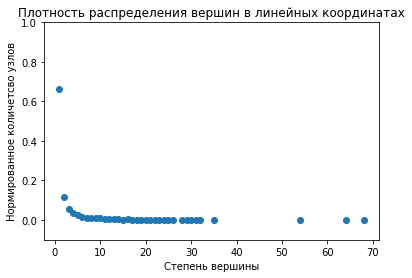

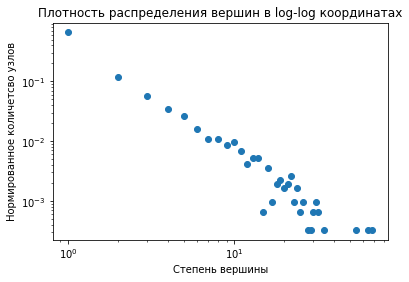

In [16]:
# импорт необходимых библиотек
import numpy as np
import matplotlib.pyplot as plt

# создание словаря частот степеней вершин в графе
d = {}
for i in graph.degree():
    d[i[1]] = d.get(i[1],0)+1
key = np.array(list(d.keys()))
val = np.array(list(d.values()))
# отрисовка полученного результата в линейных координатах
plt.scatter(key,val/sum(val))
plt.xlabel('Степень вершины')
plt.ylabel('Нормированное количетсво узлов')
plt.title('Плотность распределения вершин в линейных координатах')
plt.ylim(-0.1,1)
plt.savefig('Плотность распределения степеней вершин в линейных координатах.png')
plt.show()

# отрисовка полученного результата в log-log координатах
plt.scatter(key,val/sum(val))
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Степень вершины')
plt.ylabel('Нормированное количетсво узлов')
plt.title('Плотность распределения вершин в log-log координатах')
plt.savefig('Плотность распределения вершин в log-log координатах')

plt.show()

## Cumulative Distribution plot

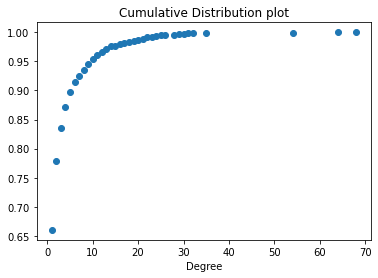

In [17]:
key,val = [],[]
d = {}
# создание словаря частот степеней вершин в графе 
for i in graph.degree():
    d[i[1]] = d.get(i[1],0)+1
# создание упорядоченных рядов значений для отрисовки cdf
for i in sorted(d):
    key.append(i)
    val.append(d[i])
cs = np.cumsum(val)
# отрисовка cdf
plt.scatter(sorted(key), cs/max(cs))
plt.title("Cumulative Distribution plot")
plt.xlabel("Degree")
plt.savefig('Cumulative Distribution plot')

plt.show()

## Выявление сообществ (алгоритм Гирвана-Ньюмана)

In [17]:
# установка библиотеки с Лувенским алгоритмом
!pip install python-louvain

You should consider upgrading via the 'C:\Users\nadya\anaconda3_1\python.exe -m pip install --upgrade pip' command.


In [97]:
from community import community_louvain

# применение Лувенского алгоритма к графу, получаем словарь вершин со значениями номеров сообщества
partition_object = community_louvain.best_partition(graph)
# количество выделенных сообщества
values = [partition_object.get(node) for node in graph.nodes()]
print(f'Количество выявленных сообществ: {len(set(values))}')

TypeError: Bad graph type, use only non directed graph

In [19]:
# список цветов для раскрашивания 
color_list = ["#51a8ff","#f80a0e","#01f3aa","#b63ff1","#95d700","#310090","#a3ff67","#ac00bc","#01d658","#fa6bff",
"#85ff7e","#4c008c","#cbff69","#6f68ff","#d9d200","#012294","#fdff62","#710093","#64ff9e","#f800a2","#00a028","#b871ff",
"#2b8e00","#bc009f","#b2ff91","#42006c","#fffc73","#004ec0","#a4b400","#7876ff","#5c9600","#ff7ef3","#019737","#ff50be",
"#01f8d5","#ef0020","#58f7ff","#fe005b","#7cffd1","#e1006e","#00a467","#b40066","#e8ff81","#200046","#ffe76a","#013e98",
"#b5a800","#016fdc","#e69300","#6c9bff","#ff7c18","#02b2f1","#ff5c21","#00d9cf","#ff4c47","#02a1a1","#a11a00","#66c8ff",
"#ac0022","#c6ffa0","#560053","#e7ff9e","#1f0035","#ffd55a","#002b63","#cc9700","#0289d0","#c57900","#0066a6","#ffbf62",
"#170027","#ffee9c","#001b30","#ffd574","#005088","#b15000","#8fc1ff","#792000","#c2fffc","#a0003a","#d1ffcd","#710049",
"#00743b","#ff5594","#114b00","#ffa8ee","#5e7100","#a9adff","#8d6e00","#c5cbff","#1b3b00","#ff90d0","#005831","#ff6d97",
"#00856f","#900053","#b5e3ff","#581400","#fbf8ff","#00181b","#ff7b6c","#002e16","#ffc0f4","#2a2c00","#ffd9f0","#261300",
"#ffece8","#4c0023","#ffe0b4","#00324f","#ffbc85","#002e28","#ff8496","#017695","#ffa686","#431d00","#685e00","#64001f",
"#7c5400","#703500"]

# создание палитры цветов для нашего разделения на сообщества
color_list = color_list[0:len(set(values))]
# создание массива Pandas для присвоения цвета к номеру сообщества
color_dict = pd.Series(color_list,
        index=np.arange(0,len(set(values)))).to_dict()
# заменяем номера сообществ на цвета в словаре 
for key, value in partition_object.items():
    partition_object[key] = color_dict[value]

# добавляем к вершинам графа атрибут цвета
nx.set_node_attributes(graph, partition_object, 'color')

In [20]:
# https://gist.github.com/maciejkos/e3bc958aac9e7a245dddff8d86058e17
def draw_graph3(networkx_graph,notebook=True,output_filename='graph.html',show_buttons=True,only_physics_buttons=False,
                height=None,width=None,bgcolor=None,font_color=None,pyvis_options=None):
    """
    Функция принимает на вход граф networkx и преобразует его в pyvis граф с множеством атрибутов
    , затем отрисовывает полученный граф
    notebook - показывать ли граф в Jupyter Notebook
    output_filename - как назвать файл с получившейся визуализацией
    show_buttons - показывать ли кнопки управления визуализацией
    only_physics_buttons - показывать ли кнопки управления визуализацией отвечающие за движения графа
    height - высота окна визуализации
    width - ширина окна визуализации
    bgcolor - цвет фона
    font_color - цвет подписей
    pyvis_options - доп опции pyvis 
    """

    # импортируем библиотеку
    from pyvis import network as net

    # создаем pyvis граф
    network_class_parameters = {"notebook": notebook, "height": height, "width": width, "bgcolor": bgcolor, "font_color": font_color}
    pyvis_graph = net.Network(**{parameter_name: parameter_value for parameter_name, parameter_value in network_class_parameters.items() if parameter_value})

    # добавляем в граф вершины с атрибутами 
    for node,node_attrs in networkx_graph.nodes(data=True):
        pyvis_graph.add_node(node,**node_attrs,default_node_size=15, default_edge_weight=1)

    # добавление связей в граф с атрибутами
    for source,target,edge_attrs in networkx_graph.edges(data=True):
        if not 'value' in edge_attrs and not 'width' in edge_attrs and 'weight' in edge_attrs:
            edge_attrs['value']=edge_attrs['weight']
        pyvis_graph.add_edge(source,target,**edge_attrs)

    # включение кнопок управления графом 
    if show_buttons:
        if only_physics_buttons:
            pyvis_graph.show_buttons(filter_=['physics'])
        else:
            pyvis_graph.show_buttons()

    # добавление специальных опций графу
    if pyvis_options:
        pyvis_graph.set_options(pyvis_options)

    # возвращает html файл, который также сохраняется и выводится на экран
    return pyvis_graph.show(output_filename)

In [21]:
# применянем функцию к нашему графу с выявленными сообществами 
draw_graph3(graph, height = '1000px', width = '1000px', 
            show_buttons=False,
            output_filename='graph_output_communities.html', notebook=True)

In [23]:
from pyvis.network import Network
import networkx as nx
# отбираем сообщество, где находится вершина brand
selected_nodes = [n for n,v in graph.nodes(data=True) if v['color'] == list(graph.nodes['brand'].values())[0]]  
# сохраняем в переменную подграф с сообществом около вершины brand
sub_graph = graph.subgraph(selected_nodes)
# рисуем подграф
net = Network(height='750px', width='100%', font_color='black',notebook=True)
net.from_nx(sub_graph,default_node_size=15, default_edge_weight=1, show_edge_weights=False)
net.toggle_physics(True)
# выводим на экран и сохраняем рисунок
net.show('mysubgraph_brand.html')

In [24]:
# отбираем сообщество, где находится вершина Toyota
selected_nodes = [n for n,v in graph.nodes(data=True) if v['color'] == list(graph.nodes['Toyota'].values())[0]]  
# сохраняем в переменную подграф с сообществом около вершины Toyota
sub_graph = graph.subgraph(selected_nodes)
# рисуем подграф
net = Network(height='750px', width='100%', font_color='black',notebook=True)
net.from_nx(sub_graph,default_node_size=15, default_edge_weight=1, show_edge_weights=False)
net.repulsion(node_distance=200, spring_length=100)
net.toggle_physics(True)
# выводим на экран и сохраняем рисунок
net.show('mysubgraph_Toyota.html')

In [26]:
# отбираем сообщество, где находится вершина Lady Gaga
selected_nodes = [n for n,v in graph.nodes(data=True) if v['color'] == list(graph.nodes['Lady Gaga'].values())[0]]  
# сохраняем в переменную подграф с сообществом около вершины Lady Gaga
sub_graph = graph.subgraph(selected_nodes)
# рисуем подграф
net = Network(height='750px', width='100%',  font_color='blue',notebook=True)
net.from_nx(sub_graph,default_node_size=15, default_edge_weight=1, show_edge_weights=False)
net.toggle_physics(True)
# выводим на экран и сохраняем рисунок
net.show('mysubgraph_lady_gaga.html')

In [27]:
# отбираем сообщество, где находится вершина Multinational companies headquartered in the United States
selected_nodes = [n for n,v in graph.nodes(data=True) if v['color'] == list(graph.nodes['Multinational companies headquartered in the United States'].values())[0]]  
# сохраняем в переменную подграф с сообществом около вершины Multinational companies headquartered in the United States
sub_graph = graph.subgraph(selected_nodes)
# рисуем подграф
net = Network(height='750px', width='100%', font_color='black',notebook=True)
net.repulsion(node_distance=250, spring_length=150)

net.from_nx(sub_graph,default_node_size=15, default_edge_weight=1, show_edge_weights=False)
net.toggle_physics(True)
# выводим на экран и сохраняем рисунок
net.show('mysubgraph_usa_brands.html')

In [28]:
# отбираем сообщество, где находится вершина Fake news website
selected_nodes = [n for n,v in graph.nodes(data=True) if v['color'] == list(graph.nodes['Fake news website'].values())[0]]  
# сохраняем в переменную подграф с сообществом около вершины Fake news website
sub_graph = graph.subgraph(selected_nodes)
# рисуем подграф
net = Network(height='750px', width='100%', font_color='black',notebook=True)
net.from_nx(sub_graph,default_node_size=15, default_edge_weight=1, show_edge_weights=False)
net.repulsion(node_distance=200, spring_length=50)

net.toggle_physics(True)
# выводим на экран и сохраняем рисунок
net.show('mysubgraph_fake_news.html')

In [57]:
selected_nodes = [n for n,v in graph.nodes(data=True) if v['color'] == list(graph.nodes['Apple Inc'].values())[0]]  
sub_graph = graph.subgraph(selected_nodes)
net = Network(height='750px', width='100%', font_color='black',notebook=True)
net.from_nx(sub_graph,default_node_size=15, default_edge_weight=1, show_edge_weights=False)
net.toggle_physics(True)
net.repulsion(node_distance=300, spring_length=50)

net.show('mysubgraph_apple.html')

In [36]:
selected_nodes = [n for n,v in graph.nodes(data=True) if v['color'] == list(graph.nodes['Chanel'].values())[0]]  
sub_graph = graph.subgraph(selected_nodes)
net = Network(height='750px', width='100%', font_color='black',notebook=True)
net.from_nx(sub_graph,default_node_size=15, default_edge_weight=1, show_edge_weights=False)
net.toggle_physics(True)
net.show('mysubgraph_Chanel.html')

In [37]:
scale=5 # Scaling the size of the nodes by 10*degree
d = dict(graph.degree)

#Updating dict
d.update((x, scale*y) for x, y in d.items())

#Setting up size attribute
nx.set_node_attributes(graph,d,'size')

G2 = Network(height='750px', width='100%', font_color='black',notebook=True)
G2.from_nx(graph)
G2.show("graph_sized.html")

In [40]:
selected_nodes = [n for n,v in graph.nodes(data=True) if v['size'] > 100]  
sub_graph = graph.subgraph(selected_nodes)
net = Network(height='750px', width='100%', font_color='black',notebook=True)
net.from_nx(sub_graph,default_node_size=15, default_edge_weight=1, show_edge_weights=False)
net.repulsion(node_distance=500, spring_length=500)
net.toggle_physics(True)
net.show('graph_sized_only_big.html')

In [42]:
selected_nodes = [n for n,v in graph.nodes(data=True) if v['color'] == list(graph.nodes['Apple Inc'].values())[0]]  
sub_graph = graph.subgraph(selected_nodes)
net = Network(height='750px', width='100%', font_color='black',notebook=True)
net.from_nx(sub_graph,default_node_size=15, default_edge_weight=1, show_edge_weights=False)
net.repulsion(node_distance=500, spring_length=100)
net.toggle_physics(True)
net.show('graph_apple.html')